In [1207]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import warnings
from pmdarima import auto_arima
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from datetime import timedelta
from datetime import date
import numpy as np
import pyodbc
from sklearn.cluster import KMeans

In [1208]:
base2025=pd.read_csv("Fact 2024-2025.csv")

In [1209]:
base2023=pd.read_csv("Fact 2022-2023.csv")

In [1210]:
base2021=pd.read_csv("Fact 2021.csv")

In [1211]:
base2020=pd.read_csv("Fact 2020.csv")

In [1212]:
Base=pd.concat([base2025,base2023])

In [1213]:
Base=Base.dropna()

In [1214]:
Base=Base[Base['Ancho_Largo_UOM_c'].isin(['CMS','PULG'])]

In [1215]:
def PulgtoCM (a):
    Pulg=a[a['Ancho_Largo_UOM_c']=='PULG']
    CMS=a[a['Ancho_Largo_UOM_c']=='CMS']
    Pulg['Ancho_CMS']=Pulg['Ancho_c']*2.54
    CMS['Ancho_CMS']=CMS['Ancho_c']*1
    base=pd.concat([Pulg,CMS])
    return base


In [1216]:
Base=PulgtoCM(Base)

In [1217]:
Base.columns

Index(['Name', 'InvoiceDate', 'PartNum', 'Ancho_c', 'Ancho_Largo_UOM_c', 'TON',
       'FacturadoBruto', 'Descuento', 'FactNeto', 'Ancho_CMS'],
      dtype='object')

In [1218]:
Agrupado= Base.groupby(['Name','InvoiceDate','PartNum'],as_index=False).agg({'TON':'sum','FactNeto':'sum','Ancho_CMS':[np.std,np.mean]}).reset_index()

In [1219]:
# Aplanar los nombres de columnas
Agrupado.columns = ['_'.join(col).strip('_') for col in Agrupado.columns.values]

In [1220]:
Agrupado=Agrupado.dropna()

In [1221]:
Agrupado['InvoiceDate']=pd.to_datetime(Agrupado['InvoiceDate'])

In [1222]:
Agrupado['Mes']=Agrupado['InvoiceDate'].dt.month

In [1223]:
Agrupado['Año']=Agrupado['InvoiceDate'].dt.year

In [1224]:
Agrupado['MesAño']=Agrupado['InvoiceDate']+ pd.offsets.MonthEnd(1)

In [1225]:
Agrupado['Precio']=Agrupado['FactNeto_sum'] / Agrupado['TON_sum']

In [1226]:
Agrupado=Agrupado.dropna()

In [1227]:
Agrupado=Agrupado[Agrupado['TON_sum']>0]

In [1228]:
Agrupado=Agrupado[Agrupado['FactNeto_sum']>0]

In [1229]:
Agrupado=Agrupado[Agrupado['Ancho_CMS_mean']<=334]

In [1230]:
Agrupado.describe()

,index,InvoiceDate,TON_sum,FactNeto_sum,Ancho_CMS_std,Ancho_CMS_mean,Mes,Año,MesAño,Precio
count,16772.000000,16772,16772.000000,1.677200e+04,16772.000000,16772.000000,16772.000000,16772.000000,16772,1.677200e+04
mean,21836.562485,2023-11-21 01:41:49.611256576,27.229000,4.893049e+05,15.109542,115.997566,6.155974,2023.414023,2023-12-06 09:46:39.809205760,2.066976e+04
min,0.000000,2022-01-04 00:00:00,0.012000,1.100000e-01,0.000000,11.505000,1.000000,2022.000000,2022-01-31 00:00:00,1.684997e-03
25%,11650.750000,2022-10-20 00:00:00,7.306500,1.138700e+05,7.071068,76.250000,3.000000,2022.000000,2022-10-31 00:00:00,1.200000e+04
50%,22076.500000,2023-11-20 12:00:00,17.422500,2.657202e+05,12.727922,93.333333,6.000000,2023.000000,2023-11-30 00:00:00,1.559004e+04
75%,32260.250000,2024-11-28 06:00:00,32.794250,5.365150e+05,19.636276,127.666667,9.000000,2024.000000,2024-11-30 00:00:00,2.180000e+04
max,43267.000000,2025-09-30 00:00:00,708.335000,2.320988e+08,137.885822,250.006100,12.000000,2025.000000,2025-10-31 00:00:00,3.048840e+07
std,12333.287280,NaN,34.121156,2.359535e+06,12.343461,59.570298,3.181696,1.128525,NaN,3.013340e+05


In [1231]:
Y=Agrupado['TON_sum']

In [1232]:
X=Agrupado[['Ancho_CMS_std', 'Ancho_CMS_mean', 'Mes', 'Año', 'Precio']]

In [1233]:
from sklearn.feature_selection import f_regression

In [1234]:
valor_f = f_regression(X, Y)
valor_f

(array([3.56819958e+01, 1.03905669e+03, 5.14235086e-02, 3.65084470e+00,
        8.57395826e-01]),
 array([2.36994776e-009, 3.10382965e-221, 8.20607284e-001, 5.60578163e-002,
        3.54481803e-001]))

In [1235]:
pasan_prueba = []
no_pasan_prueba = []
alpha = 0.05

for i in range(len(valor_f[1])):
    if valor_f[1][i] < alpha:
        pasan_prueba.append(X.columns[i])
    else:
        no_pasan_prueba.append(X.columns[i])

In [1236]:
pasan_prueba

['Ancho_CMS_std', 'Ancho_CMS_mean']

In [1237]:
no_pasan_prueba

['Mes', 'Año', 'Precio']

In [1238]:
from sklearn.preprocessing import MinMaxScaler

In [1239]:
escalador = MinMaxScaler()
escala = escalador.fit_transform(X)
x_escalada = pd.DataFrame(escala, columns=X.columns)
x_escalada

,Ancho_CMS_std,Ancho_CMS_mean,Mes,Año,Precio
0,0.173148,0.320732,0.272727,1.0,0.000405
1,0.112743,0.318636,0.454545,1.0,0.000390
2,0.055391,0.315142,0.454545,1.0,0.000390
3,0.114670,0.329118,0.454545,1.0,0.000390
4,0.139502,0.350082,0.636364,1.0,0.000371
...,...,...,...,...,...
16767,0.043962,0.347802,0.636364,1.0,0.000616
16768,0.078154,0.452304,0.636364,1.0,0.000579
16769,0.135784,0.448754,0.636364,1.0,0.000575
16770,0.138541,0.413698,0.727273,1.0,0.000575


In [1240]:
from sklearn.feature_selection import VarianceThreshold

In [1241]:
selector = VarianceThreshold()
selector.fit_transform(x_escalada)
selector.variances_

array([8.01325102e-03, 6.23810773e-02, 8.36577153e-02, 1.41499203e-01,
       9.76789823e-05])

In [1242]:
df_resultados = pd.DataFrame(valor_f[0], index = X.columns, columns=['valor_f'])#.sort_values('valor_f', ascending = False)
df_resultados['varianza'] = selector.variances_
df_resultados

,valor_f,varianza
Ancho_CMS_std,35.681996,0.008013
Ancho_CMS_mean,1039.056687,0.062381
Mes,0.051424,0.083658
Año,3.650845,0.141499
Precio,0.857396,0.000098


In [1243]:
from sklearn.feature_selection import mutual_info_regression

In [1244]:
mi = mutual_info_regression(X, Y)
mi

array([0.10200826, 0.17324082, 0.00070192, 0.00538124, 0.05525268])

In [1245]:
df_resultados['mi'] = mi
df_resultados

,valor_f,varianza,mi
Ancho_CMS_std,35.681996,0.008013,0.102008
Ancho_CMS_mean,1039.056687,0.062381,0.173241
Mes,0.051424,0.083658,0.000702
Año,3.650845,0.141499,0.005381
Precio,0.857396,0.000098,0.055253


In [1246]:
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

In [1247]:
lr = LinearRegression()
lr

LinearRegression()

In [1248]:
efs = EFS(estimator = lr,        # Use linear regression as the classifier/estimator
          min_features = 1,      # The minimum number of features to consider is 1
          max_features = 5,      # The maximum number of features to consider is 4
          scoring = 'neg_mean_absolute_error',  # The metric to use to evaluate the classifier is accuracy
          cv = 5)

In [1249]:
efs = efs.fit(X, Y)

Features: 31/31

In [1250]:
efs.best_score_

-20.182812133334373

In [1251]:
efs.best_feature_names_

('Ancho_CMS_mean',)

In [1252]:
df_resultados_efs = pd.DataFrame(efs.get_metric_dict()).T
df_resultados_efs = df_resultados_efs.sort_values('avg_score', ascending = False)
df_resultados_efs

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(1,)","[-20.40981457660815, -19.888406298304986, -22....",-20.182812,"(Ancho_CMS_mean,)",2.305626,1.793855,0.896928
11,"(1, 4)","[-20.410959032708, -19.889458397084244, -22.91...",-20.183008,"(Ancho_CMS_mean, Precio)",2.306713,1.794701,0.89735
9,"(1, 2)","[-20.41044934496686, -19.88825254854626, -22.9...",-20.184546,"(Ancho_CMS_mean, Mes)",2.306537,1.794564,0.897282
22,"(1, 2, 4)","[-20.411604992742404, -19.88930629662685, -22....",-20.184751,"(Ancho_CMS_mean, Mes, Precio)",2.307639,1.795422,0.897711
17,"(0, 1, 4)","[-20.1977256284711, -19.830873477320345, -22.4...",-20.234723,"(Ancho_CMS_std, Ancho_CMS_mean, Precio)",1.762632,1.371388,0.685694
5,"(0, 1)","[-20.19651035990581, -19.83001937836198, -22.4...",-20.234859,"(Ancho_CMS_std, Ancho_CMS_mean)",1.76122,1.370289,0.685145
26,"(0, 1, 2, 4)","[-20.19893751988382, -19.830811024064907, -22....",-20.236652,"(Ancho_CMS_std, Ancho_CMS_mean, Mes, Precio)",1.763844,1.37233,0.686165
15,"(0, 1, 2)","[-20.19770591218716, -19.82996528311498, -22.4...",-20.236781,"(Ancho_CMS_std, Ancho_CMS_mean, Mes)",1.762416,1.37122,0.68561
23,"(1, 3, 4)","[-20.391747518416583, -19.848920660993077, -23...",-20.245963,"(Ancho_CMS_mean, Año, Precio)",2.513933,1.955926,0.977963
10,"(1, 3)","[-20.3905054525184, -19.8478313917517, -23.442...",-20.246594,"(Ancho_CMS_mean, Año)",2.513724,1.955763,0.977881


[]

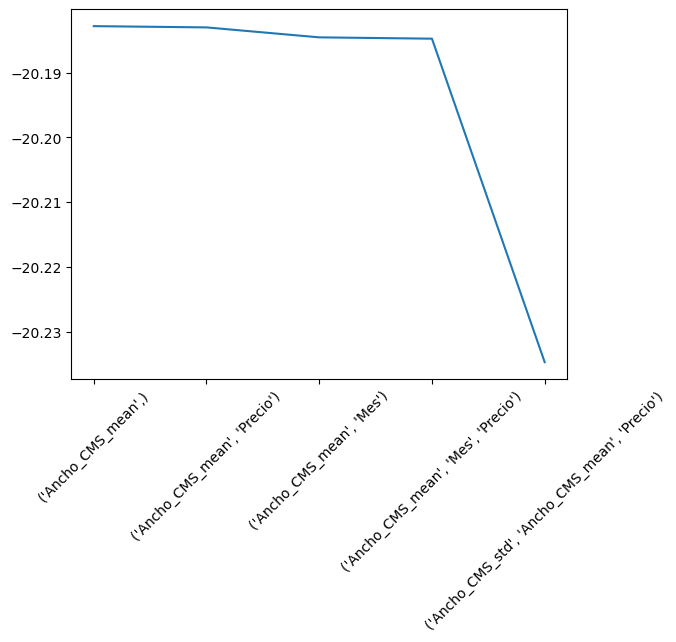

In [1253]:
plt.figure()

plt.plot(
    df_resultados_efs.iloc[:5].feature_names.astype(str),
    df_resultados_efs.iloc[:5].avg_score,
)

plt.xticks(rotation = 45)

plt.plot()

In [1254]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [1255]:
sfs = SFS(estimator = lr,        # Use liner regression as the classifier/estimator
          k_features = (1, 5),  # Consider any feature combination between 1 and 8
          forward = False,       # Set forward to True when we want to perform SFS
          scoring = 'neg_mean_absolute_error',  # The metric to use to evaluate the classifier is accuracy
          cv=5)

In [1256]:
sfs = sfs.fit(X, Y)

In [1257]:
sfs.k_score_

-20.182812133334373

In [1258]:
sfs.k_feature_names_

('Ancho_CMS_mean',)

In [1259]:
pd.DataFrame(sfs.subsets_).T.sort_values('avg_score', ascending = False)

,feature_idx,cv_scores,avg_score,feature_names
1,"(1,)","[-20.40981457660815, -19.888406298304986, -22....",-20.182812,"(Ancho_CMS_mean,)"
2,"(1, 4)","[-20.410959032708, -19.889458397084244, -22.91...",-20.183008,"(Ancho_CMS_mean, Precio)"
3,"(1, 2, 4)","[-20.411604992742404, -19.88930629662685, -22....",-20.184751,"(Ancho_CMS_mean, Mes, Precio)"
4,"(0, 1, 2, 4)","[-20.19893751988382, -19.830811024064907, -22....",-20.236652,"(Ancho_CMS_std, Ancho_CMS_mean, Mes, Precio)"
5,"(0, 1, 2, 3, 4)","[-20.181132079647842, -19.789998425716412, -22...",-20.300705,"(Ancho_CMS_std, Ancho_CMS_mean, Mes, Año, Precio)"


In [1260]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [1261]:
Agrupado.columns

Index(['index', 'Name', 'InvoiceDate', 'PartNum', 'TON_sum', 'FactNeto_sum',
       'Ancho_CMS_std', 'Ancho_CMS_mean', 'Mes', 'Año', 'MesAño', 'Precio'],
      dtype='object')

In [1262]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(Agrupado[['TON_sum',
       'Ancho_CMS_std', 'Ancho_CMS_mean', 'Precio']])

In [1263]:
scaled_data

array([[-0.30600695,  0.7101244 , -0.47000606, -0.02763051],
       [-0.5030167 ,  0.03533071, -0.47839975, -0.02909072],
       [-0.56825677, -0.60535197, -0.49238924, -0.02909072],
       ...,
       [-0.34554372,  0.29272162,  0.04256892, -0.01040967],
       [ 0.30600697,  0.32352523, -0.09778765, -0.01046239],
       [-0.5783974 ,  1.75883867, -0.03915769, -0.011436  ]])

In [1264]:
X_Scaled=scaled_data

In [1265]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_data)

In [1266]:
explained_variance_ratio = pca.explained_variance_ratio_

In [1267]:
explained_variance_ratio.sum()

0.81893301188677

In [1268]:
pca=pd.DataFrame(principal_components)

In [1269]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(principal_components)

In [1270]:
labels = kmeans.labels_ # Cluster label for each data point
centroids = kmeans.cluster_centers_ # Coordinates of the cluster centroids

In [1271]:
scaled_data = scaler.fit_transform(Agrupado[Agrupado['InvoiceDate']>='2024/01/01'][['TON_sum',
       'Ancho_CMS_std', 'Ancho_CMS_mean', 'Precio']])

In [1272]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_data)

In [1273]:
PCA_L3M=pd.DataFrame(principal_components)

In [1274]:
Agrupado3M=Agrupado[Agrupado['InvoiceDate']>='2024/01/01']

In [1275]:
Agrupado3M['Kmeans']=kmeans.fit(PCA_L3M).labels_

Elasticidad de la demanda por Grupos

In [1276]:
##Grupo 1

In [1277]:
Grupo_0=Agrupado3M[Agrupado3M['Kmeans']==3]

In [1278]:
Grupo_0_Agrupado=Grupo_0.groupby(['PartNum','Año','Mes','MesAño'],as_index=False).agg({'TON_sum':'sum','FactNeto_sum':'sum'})

In [1279]:
Grupo_0_Agrupado['Precio']=Grupo_0_Agrupado['FactNeto_sum']/Grupo_0_Agrupado['TON_sum']

In [1280]:
Grupo_0_Agrupado['Year_Month']=Grupo_0_Agrupado['MesAño'].dt.to_period('M')
Grupo_0_Agrupado=Grupo_0_Agrupado.sort_values(['PartNum','Year_Month'])
Grupo_0_Agrupado['Month_Num']=Grupo_0_Agrupado['Año']*12+Grupo_0_Agrupado['Mes']
Grupo_0_Agrupado['consec_group']=Grupo_0_Agrupado.groupby('PartNum')['Month_Num'].diff().ne(1).cumsum()

In [1281]:
consec_counts = (
    Grupo_0_Agrupado.groupby(['PartNum', 'consec_group'])
    .size()
    .reset_index(name='count_consec')
)

In [1282]:
cats_validas = consec_counts.loc[consec_counts['count_consec'] >=1, 'PartNum'].unique()

In [1283]:
cats_validas

array(['CABO14', 'CABO17', 'CABO18', 'CABO19', 'CABO22', 'CABO22H',
       'CABO230', 'CABO230H', 'CABO24', 'CABO24H', 'CRC11', 'CRC11H',
       'CRC12', 'CRC12H', 'CRC14', 'CRC14H', 'CRC16', 'CRC16H', 'CRC18',
       'CRC18H', 'CRC20', 'CRC20H', 'CRC22', 'CRC22H', 'CRC24', 'CRC24H',
       'CRC26', 'CRC28', 'CRC28H', 'L125M1', 'L125M2', 'L160M1', 'L180M1',
       'L180M1H', 'L205M1', 'L205M1H', 'L205M2', 'L205M3', 'L250M2H',
       'L300', 'L300M1', 'L300m2', 'L330', 'L400', 'L400H', 'L450',
       'L500', 'LCB150M1', 'LCB160M1', 'LCB180M1', 'LCB205', 'LCB205M1',
       'LCB205M1H', 'LKT300', 'LKT450', 'LKT450K', 'LKT500', 'LKT500K',
       'LKT500T', 'M12', 'M22', 'R112M1', 'R112M2', 'RSP14T', 'RSP180',
       'RSP205', 'RSP230', 'RSP230H'], dtype=object)

In [1284]:
Agrupado_0_Filtrado=Grupo_0_Agrupado[Grupo_0_Agrupado['PartNum'].isin(cats_validas)]

In [1285]:
Agrupado_0_Filtrado=Agrupado_0_Filtrado.groupby(['Year_Month']).agg({'TON_sum':'sum', 'FactNeto_sum':'sum'}).reset_index()

In [1286]:
Agrupado_0_Filtrado

,Year_Month,TON_sum,FactNeto_sum
0,2024-01,1366.6270,27927847.57
1,2024-02,1384.1630,26869574.49
2,2024-03,2109.8630,39702110.83
3,2024-04,2314.6550,43458409.61
4,2024-05,2542.7740,50037466.03
5,2024-06,2299.7330,47396157.14
6,2024-07,3367.1920,65805352.99
7,2024-08,3004.7610,53162192.11
8,2024-09,2463.5890,45245602.99
9,2024-10,2312.0290,40688455.19


In [1287]:
Agrupado_0_Filtrado['Precio']=Agrupado_0_Filtrado['FactNeto_sum']/Agrupado_0_Filtrado['TON_sum']

In [1288]:
Agrupado_0_Filtrado['diff_toneladas'] = Agrupado_0_Filtrado['TON_sum'].diff()

In [1289]:
Agrupado_0_Filtrado['diff_Precio'] = Agrupado_0_Filtrado['Precio'].diff()

In [1290]:
Agrupado_0_Filtrado

,Year_Month,TON_sum,FactNeto_sum,Precio,diff_toneladas,diff_Precio
0,2024-01,1366.6270,27927847.57,20435.603548,NaN,NaN
1,2024-02,1384.1630,26869574.49,19412.146178,17.5360,-1023.457370
2,2024-03,2109.8630,39702110.83,18817.388063,725.7000,-594.758115
3,2024-04,2314.6550,43458409.61,18775.329200,204.7920,-42.058862
4,2024-05,2542.7740,50037466.03,19678.298594,228.1190,902.969394
5,2024-06,2299.7330,47396157.14,20609.417328,-243.0410,931.118734
6,2024-07,3367.1920,65805352.99,19543.094956,1067.4590,-1066.322372
7,2024-08,3004.7610,53162192.11,17692.652464,-362.4310,-1850.442492
8,2024-09,2463.5890,45245602.99,18365.726990,-541.1720,673.074526
9,2024-10,2312.0290,40688455.19,17598.592055,-151.5600,-767.134935


In [1291]:
Agrupado_0_Filtrado[['diff_toneladas','diff_Precio']].corr()

,diff_toneladas,diff_Precio
diff_toneladas,1.00000,0.09145
diff_Precio,0.09145,1.00000


Por Parte

In [1320]:
partes={}

In [1321]:
for i in Agrupado3M['PartNum'].unique():
    base=Agrupado3M[Agrupado3M['PartNum']==i]
    base=base[base['Kmeans']==3]
    base=base.groupby(['PartNum','Año','Mes','MesAño'],as_index=False).agg({'TON_sum':'sum','FactNeto_sum':'sum'})
    base['Year_Month']=base['MesAño'].dt.to_period('M')
    base=base.sort_values(['PartNum','Year_Month'])
    base['Month_Num']=base['Año']*12+base['Mes']
    base['consec_group']=base.groupby('PartNum')['Month_Num'].diff().ne(1).cumsum() 
    consec_counts = (
    base.groupby(['PartNum', 'consec_group'])
    .size()
    .reset_index(name='count_consec'))
    cats_validas = consec_counts.loc[consec_counts['count_consec'] >=3, 'PartNum'].unique()
    if (len(consec_counts.loc[consec_counts['count_consec'] >=3, 'PartNum'].unique())==0):
        break
    else:
        Base_Filtrado=base[base['PartNum'].isin(cats_validas)]
        Base_Filtrado=Base_Filtrado.groupby(['Year_Month']).agg({'TON_sum':'sum', 'FactNeto_sum':'sum'}).reset_index()
        Base_Filtrado['Precio']=Base_Filtrado['FactNeto_sum']/Base_Filtrado['TON_sum']
        Base_Filtrado['diff_toneladas'] = Base_Filtrado['TON_sum'].diff()
        Base_Filtrado['diff_precio'] = Base_Filtrado['Precio'].diff()
        partes.update({i:Base_Filtrado[['diff_toneladas','diff_precio']].corr().iloc[0,1]})
    
    
    

In [1322]:
Partesdf=pd.DataFrame.from_dict(partes,orient='index')

In [1323]:
Partesdf

""
